# Illustration of audio transforms

[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/mindspore/blob/master/docs/api/api_python_en/samples/dataset/audio_gallery.ipynb)

This example illustrates the various transforms available in the [mindspore.dataset.audio](https://www.mindspore.cn/docs/en/master/api_python/mindspore.dataset.transforms.html#module-mindspore.dataset.audio) module.

## Preparation

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from IPython.display import Audio
from download import download

import mindspore.dataset as ds
import mindspore.dataset.audio as audio

ds.config.set_seed(5)

# cication: LibriSpeech http://www.openslr.org/12
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/84-121123-0000.wav"
download(url, './84-121123-0000.wav', replace=True)
wav_file = "84-121123-0000.wav"

def plot_waveform(waveform, sr, title="Waveform"):
    if waveform.ndim == 1:
        waveform = waveform[np.newaxis, :]
    num_channels, num_frames = waveform.shape
    time_axis = np.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    _, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)



file_sizes: 100%|███████████████████████████| 67.0k/67.0k [00:00<00:00, 764kB/s]
Successfully downloaded file to ./84-121123-0000.wav


## Spectrogram

To create a spectrogram from an audio signal, you can use [mindspore.dataset.audio.Spectrogram](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Spectrogram.html#mindspore.dataset.audio.Spectrogram).

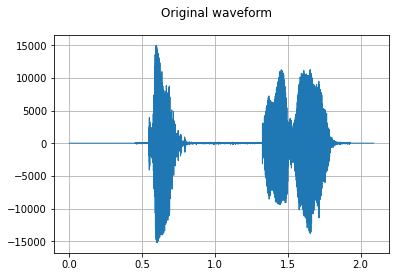

In [2]:
sample_rate, waveform = wavfile.read(wav_file)

plot_waveform(waveform, sample_rate, title="Original waveform")
Audio(waveform, rate=sample_rate)

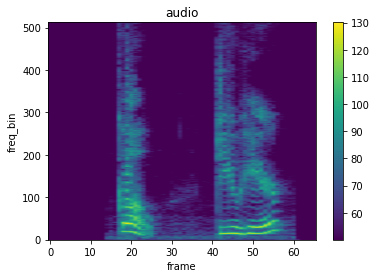

In [3]:
# Perform transform
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = audio.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode=audio.BorderType.REFLECT,
    power=2.0,
)

spec = spectrogram(waveform)
plot_spectrogram(spec, title="audio")

## GriffinLim

To recover a waveform from a spectrogram, you can use [mindspore.dataset.audio.GriffinLim](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.GriffinLim.html#mindspore.dataset.audio.GriffinLim).

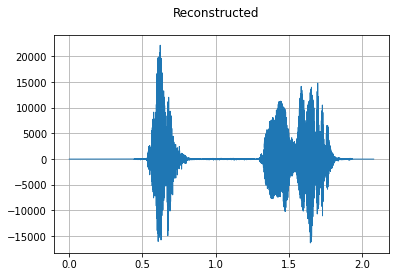

In [4]:
n_fft = 1024
win_length = None
hop_length = 512

spec = audio.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)(waveform)

griffin_lim = audio.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)

reconstructed_waveform = griffin_lim(spec)

plot_waveform(reconstructed_waveform, sample_rate, title="Reconstructed")
Audio(reconstructed_waveform, rate=sample_rate)

## Mel Filter Bank

To generate frequency transformation matrix, use [mindspore.dataset.audio.melscale_fbanks](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.melscale_fbanks.html#mindspore.dataset.audio.melscale_fbanks).

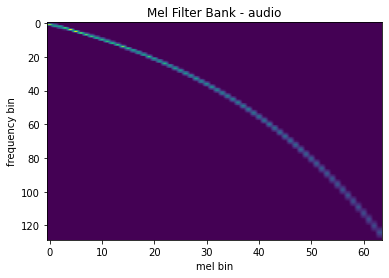

In [5]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = audio.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm=audio.NormType.SLANEY,
)

plot_fbank(mel_filters, "Mel Filter Bank - audio")

## MelSpectrogram

To create a mel-scale spectrogram for a raw audio signal, use [mindspore.dataset.audio.MelSpectrogram](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.MelSpectrogram.html#mindspore.dataset.audio.MelSpectrogram).

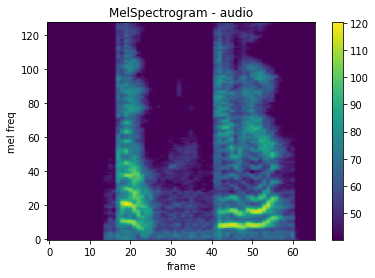

In [6]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = audio.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode=audio.BorderType.REFLECT,
    power=2.0,
    norm=audio.NormType.SLANEY,
    onesided=True,
    n_mels=n_mels,
    mel_scale=audio.MelType.HTK,
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(melspec, title="MelSpectrogram - audio", ylabel="mel freq")

## MFCC

[mindspore.dataset.audio.MFCC](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.MFCC.html#mindspore.dataset.audio.MFCC) returns Mel Frequency Cepstrum Coefficient for a raw audio signal.

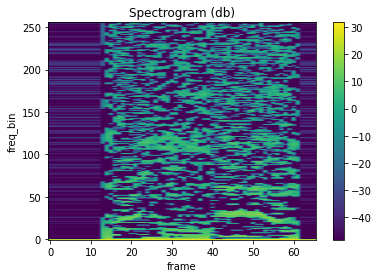

In [7]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = audio.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "win_length": n_fft,
        "f_min": 0.0,
        "f_max": sample_rate // 2,
        "pad": 0,
        "pad_mode": audio.BorderType.REFLECT,
        "power": 2.0,
        "n_mels": n_mels,
        "normalized": False,
        "center": True,
        "onesided": True,
        "window": audio.WindowType.HANN,
        "hop_length": hop_length,
        "norm": audio.NormType.NONE,
        "mel_scale": audio.MelType.HTK,
    },
)

mfcc = mfcc_transform(waveform)
plot_spectrogram(mfcc)

## LFCC

[mindspore.dataset.audio.LFCC](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.LFCC.html#mindspore.dataset.audio.LFCC) returns Linear Frequency Cepstral Coefficient for a raw audio signal.


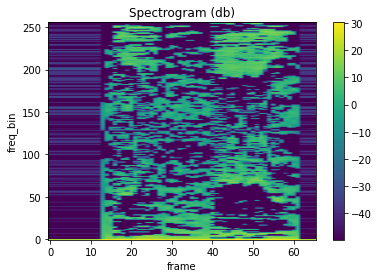

In [8]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = audio.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": n_fft,
        "hop_length": hop_length,
        "pad": 0,
        "window": audio.WindowType.HANN,
        "power": 2.0,
        "normalized": False,
        "center": True,
        "pad_mode": audio.BorderType.REFLECT,
        "onesided": True
    },
)

lfcc = lfcc_transform(waveform)
plot_spectrogram(lfcc)

## Process Wav File In Dataset Pipeline

Use the [mindspore.dataset.GeneratorDataset](https://mindspore.cn/docs/en/master/api_python/dataset/mindspore.dataset.GeneratorDataset.html#mindspore.dataset.GeneratorDataset) to read wav files into dataset pipeline and then we can do further transforms based on pipeline.

number of samples in dataset: 3
>>>>> after gain


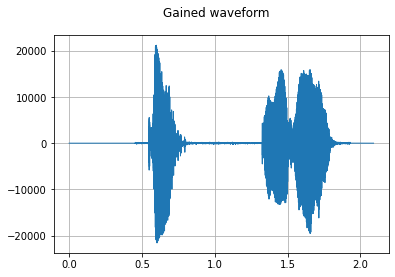

In [9]:
import scipy.io.wavfile as wavfile
import mindspore.dataset as ds
import mindspore.dataset.audio as audio

# Define dataloader
class DataLoader():
    def __init__(self):
        self.sample_rate, self.wave = wavfile.read("84-121123-0000.wav")
    def __next__(self):
        return next(self.data)
    def __iter__(self):
        self.data = iter([(self.wave, self.sample_rate), (self.wave, self.sample_rate), (self.wave, self.sample_rate)])
        return self

# Load 3 waveforms into dataset pipeline
dataset = ds.GeneratorDataset(DataLoader(), column_names=["wav", "sample_rate"], shuffle=False)

# check the sample numbers in dataset
print("number of samples in dataset:", dataset.get_dataset_size())

# apply gain on "wav" column
dataset = dataset.map(audio.Gain(gain_db=3.0), input_columns=["wav"])

# check results, specify the output type to NumPy for drawing
print(">>>>> after gain")
for waveform, sample_rate  in dataset.create_tuple_iterator(output_numpy=True):
    # show the wav
    plot_waveform(waveform, sample_rate, title="Gained waveform")
    # after drawing one wav, break
    break